<a href="https://colab.research.google.com/github/Rocky12312/Sentiment-analysis/blob/master/Sentiment_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/My\ Drive/Tweet_sentiment_extraction/tse

/content/drive/My Drive/Tweet_sentiment_extraction/tse


In [3]:
pip install transformers

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Reading the input dataframes

In [0]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_sample_submission = pd.read_csv("sample_submission.csv")

In [6]:
df_train.head(5)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [7]:
df_test.head(5)

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [8]:
df_sample_submission.head(5)

,textID,selected_text
0,f87dea47db,NaN
1,96d74cb729,NaN
2,eee518ae67,NaN
3,01082688c6,NaN
4,33987a8ee5,NaN


Basically in this problem what we have to do is to train a model on our training data such that we can find the selected_text data column corresponding to our test data which is basically the part of sentiment text, which help in determination whether our sentiment is neutral,positive or negative.

This is like question answering task.

Getting the info about the dataframes

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


In [11]:
df_train.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

As we know that we have the text and selected_text column are of type string so better is to convert them to string type. 

In [0]:
df_train["text"] = df_train["text"].astype(str)
df_train["selected_text"] = df_train["selected_text"].astype(str)
df_train["sentiment"] = df_train["sentiment"].astype(str)

In [0]:
df_test["text"] = df_test["text"].astype(str)
df_test["sentiment"] = df_test["sentiment"].astype(str)

In [14]:
df_train.isnull().sum()

textID           0
text             0
selected_text    0
sentiment        0
dtype: int64

In [0]:
import re
import string
import nltk
from nltk.corpus import stopwords

#Cleaning the text
def Cleaning_text(text_data):
  for i in range(len(text_data)):
    #Lowering the text and removing all the hypertexts
    text = text_data[i].lower()
    text = re.sub(r"https?://www\.\S+\.com","",text)
    #Splitting the text into tokens
    tokens = text.split()
    #Preparing regex for character filtering
    re_punct = re.compile("[%s]"% re.escape(string.punctuation))
    tokens = [re_punct.sub(" ", word) for word in tokens]
    #Now joining tokens back to form sentence
    text_data[i] = " ".join(tokens)
  return text_data

In [0]:
df_train["text"] = Cleaning_text(df_train["text"])

In [0]:
df_train["selected_text"] = Cleaning_text(df_train["selected_text"])

Now as our data is tweet data so it is very much possible that data will be containing links, Shortforms, Contractions along with usual textual noise so one of our main step will be text cleaning.

Mainly we will be cleaning the text and selected text column as for our sentiment column we only need to encode it.

In [18]:
df_train["sentiment"].value_counts()

neutral     11118
positive     8582
negative     7781
Name: sentiment, dtype: int64

Plotting the classwise counts of sentiments from training and testing data

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


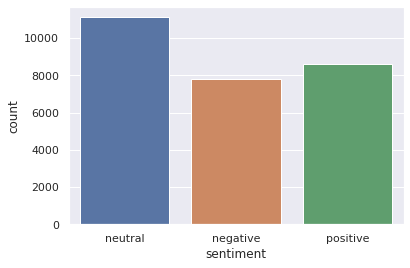

In [19]:
import seaborn as sns
sns.set(style = "darkgrid")
ax = sns.countplot(x = "sentiment",data = df_train)

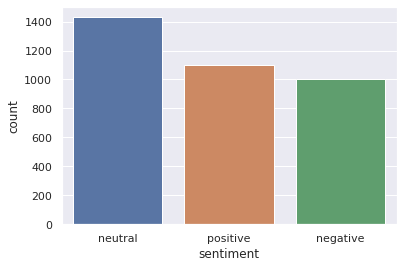

In [20]:
ax1 = sns.countplot(x = "sentiment",data = df_test)

From the above plots it is clear that we have imbalanced data both in our training and testing data but as our task is not to predict the labels but to extract the selected_text from text which help in providing sentiment so we will not go for balancing the dataset.

In [21]:
df_train.head(5)

,textID,text,selected_text,sentiment
0,cb774db0d1,i d have responded if i were going,i d have responded if i were going,neutral
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative
2,088c60f138,my boss is bullying me,bullying me,negative
3,9642c003ef,what interview leave me alone,leave me alone,negative
4,358bd9e861,sons of why couldn t they put them on th...,sons of,negative


So as we have preprocessed our data so now what we will do is manipulate our data in such a way that so that we can feed it to our model(roBERTa).

In [0]:
from transformers import *
import tokenizers

#Model max length
MAX_LEN = 140
PATH = "../tse/tf-roberta/"
#Creating the tokenizer
tokenizer = tokenizers.ByteLevelBPETokenizer(
    vocab_file=PATH+"vocab-roberta-base.json", 
    merges_file=PATH+"merges-roberta-base.txt", 
    lowercase=True,
    add_prefix_space=True
)
sentiment_id = {"positive": 1313,"negative": 2430, "neutral": 7974}

In [23]:
df_train.shape[0]

27481

We will now convert the training data into arrays that roBERTa can understand.

In [0]:
input_ids = np.ones((df_train.shape[0],MAX_LEN),dtype="int32")
attention_mask = np.zeros((df_train.shape[0],MAX_LEN),dtype="int32")
token_type_ids = np.zeros((df_train.shape[0],MAX_LEN),dtype="int32")
start_tokens = np.zeros((df_train.shape[0],MAX_LEN),dtype="int32")
end_tokens = np.zeros((df_train.shape[0],MAX_LEN),dtype="int32")

In [0]:
for k in range(df_train.shape[0]):
    
    #Finding the text1 and text2 overlap(text and selected_text)
    text1 = " "+" ".join(df_train.loc[k,"text"].split())
    text2 = " ".join(df_train.loc[k,"selected_text"].split())
    #Finding text2 starting id in text1(selected_text in text)
    idx = text1.find(text2)
    #Creating a chars array and imputing it with ones and zeros corresponding to idx
    chars = np.zeros((len(text1)))
    chars[idx:idx+len(text2)]=1
    if text1[idx-1]==" ": chars[idx-1] = 1 
    enc = tokenizer.encode(text1) 
        
    #ID_OFFSETS
    offsets = []; idx=0
    for t in enc.ids:
        w = tokenizer.decode([t])
        offsets.append((idx,idx+len(w)))
        idx += len(w)
    
    #Start end tokens
    toks = []
    for i,(a,b) in enumerate(offsets):
        sm = np.sum(chars[a:b])
        if sm>0: toks.append(i) 
        
    s_tok = sentiment_id[df_train.loc[k,"sentiment"]]
    input_ids[k,:len(enc.ids)+5] = [0] + enc.ids + [2,2] + [s_tok] + [2]
    attention_mask[k,:len(enc.ids)+5] = 1
    if len(toks)>0:
        start_tokens[k,toks[0]+1] = 1
        end_tokens[k,toks[-1]+1] = 1

In [0]:
input_ids_t = np.ones((df_test.shape[0],MAX_LEN),dtype = "int32")
attention_mask_t = np.zeros((df_test.shape[0],MAX_LEN),dtype = "int32")
token_type_ids_t = np.zeros((df_test.shape[0],MAX_LEN),dtype = "int32")

In [0]:
for k in range(df_test.shape[0]):
        
    #input id's
    text1 = " "+" ".join(df_test.loc[k,"text"].split())
    enc = tokenizer.encode(text1)                
    s_tok = sentiment_id[df_test.loc[k,"sentiment"]]
    input_ids_t[k,:len(enc.ids)+5] = [0] + enc.ids + [2,2] + [s_tok] + [2]
    attention_mask_t[k,:len(enc.ids)+5] = 1

In [0]:
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import StratifiedKFold

In [0]:
def build_model():
    ids = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    att = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    tok = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)

    config = RobertaConfig.from_pretrained(PATH + "config-roberta-base.json")
    bert_model = TFRobertaModel.from_pretrained(PATH + "pretrained-roberta-base.h5",config=config)
    x = bert_model(ids,attention_mask=att,token_type_ids = tok)
    
    x1 = tf.keras.layers.Dropout(0.1)(x[0]) 
    x1 = tf.keras.layers.Conv1D(256, 2,padding = "same")(x1)
    x1 = tf.keras.layers.LeakyReLU()(x1)
    x1 = tf.keras.layers.Conv1D(128, 2,padding = "same")(x1)
    x1 = tf.keras.layers.Dense(1)(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Activation("softmax")(x1)
    
    x2 = tf.keras.layers.Dropout(0.1)(x[0]) 
    x2 = tf.keras.layers.Conv1D(256, 2, padding = "same")(x2)
    x2 = tf.keras.layers.LeakyReLU()(x2)
    x2 = tf.keras.layers.Conv1D(128, 2, padding = "same")(x2)
    x2 = tf.keras.layers.Dense(1)(x2)
    x2 = tf.keras.layers.Flatten()(x2)
    x2 = tf.keras.layers.Activation("softmax")(x2)

    model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x1,x2])
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
    model.compile(loss = "categorical_crossentropy", optimizer=optimizer)

    return model

In [0]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    if (len(a)==0) & (len(b)==0): return 0.5
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [0]:
jac = []; VER="v0"; DISPLAY=1 # USE display=1 FOR INTERACTIVE
oof_start = np.zeros((input_ids.shape[0],MAX_LEN))
oof_end = np.zeros((input_ids.shape[0],MAX_LEN))
preds_start = np.zeros((input_ids_t.shape[0],MAX_LEN))
preds_end = np.zeros((input_ids_t.shape[0],MAX_LEN))

skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=43)
for fold,(idxT,idxV) in enumerate(skf.split(input_ids,df_train.sentiment.values)):

    print("#"*25)
    print("### FOLD %i"%(fold+1))
    print("#"*25)
    
    K.clear_session()
    model = build_model()
        
    sv = tf.keras.callbacks.ModelCheckpoint(
        "%s-roberta-%i.h5"%(VER,fold), monitor = "val_loss", verbose=1, save_best_only=True,
        save_weights_only=True, mode = "auto", save_freq = "epoch")
        
    model.fit([input_ids[idxT,], attention_mask[idxT,], token_type_ids[idxT,]], [start_tokens[idxT,], end_tokens[idxT,]], 
        epochs=3, batch_size=32, verbose=DISPLAY, callbacks=[sv],
        validation_data=([input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]], 
        [start_tokens[idxV,], end_tokens[idxV,]]))
    
    print("Loading the model")
    model.load_weights("%s-roberta-%i.h5"%(VER,fold))
    
    print("Predicting OOF")
    oof_start[idxV,],oof_end[idxV,] = model.predict([input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]],verbose=DISPLAY)
    
    print("Predicting Test0")
    preds = model.predict([input_ids_t,attention_mask_t,token_type_ids_t],verbose=DISPLAY)
    preds_start += preds[0]/skf.n_splits
    preds_end += preds[1]/skf.n_splits
    
    #Displaying fold jaccard
    all = []
    for k in idxV:
        a = np.argmax(oof_start[k,])
        b = np.argmax(oof_end[k,])
        if a>b: 
            st = df_train.loc[k,"text"]
        else:
            text1 = " "+" ".join(df_train.loc[k,"text"].split())
            enc = tokenizer.encode(text1)
            st = tokenizer.decode(enc.ids[a-1:b])
        all.append(jaccard(st,df_train.loc[k,"selected_text"]))
    jac.append(np.mean(all))
    print("FOLD %i Jaccard ="%(fold+1),np.mean(all))
    print()

#########################
### FOLD 1
#########################
Epoch 1/3
687/687 [==============================] - ETA: 0s - loss: 2.1140 - activation_loss: 1.0757 - activation_1_loss: 1.0383
Epoch 00001: val_loss improved from inf to 1.69247, saving model to v0-roberta-0.h5
687/687 [==============================] - 384s 558ms/step - loss: 2.1140 - activation_loss: 1.0757 - activation_1_loss: 1.0383 - val_loss: 1.6925 - val_activation_loss: 0.8529 - val_activation_1_loss: 0.8396
Epoch 2/3
687/687 [==============================] - ETA: 0s - loss: 1.6346 - activation_loss: 0.8397 - activation_1_loss: 0.7950
Epoch 00002: val_loss improved from 1.69247 to 1.63287, saving model to v0-roberta-0.h5
687/687 [==============================] - 383s 558ms/step - loss: 1.6346 - activation_loss: 0.8397 - activation_1_loss: 0.7950 - val_loss: 1.6329 - val_activation_loss: 0.8277 - val_activation_1_loss: 0.8051
Epoch 3/3
687/687 [==============================] - ETA: 0s - loss: 1.4962 - activatio

In [0]:
print("overall 5fold cv Jaccard =",np.mean(jac))

overall 5fold cv Jaccard = 0.705599897588033


In [0]:
all = []
for k in range(input_ids_t.shape[0]):
    a = np.argmax(preds_start[k,])
    b = np.argmax(preds_end[k,])
    if a>b: 
        st = df_test.loc[k,"text"]
    else:
        text1 = " "+" ".join(df_test.loc[k,"text"].split())
        enc = tokenizer.encode(text1)
        st = tokenizer.decode(enc.ids[a-1:b])
    all.append(st)

In [0]:
df_test["selected_text"] = all
df_test[["textID","selected_text"]].to_csv("submission.csv",index=False)
pd.set_option("max_colwidth", 60)
df_test.sample(25)

,textID,text,sentiment,selected_text
580,303a1773cf,every day of my life lately. i feel ya girl <3,neutral,every day of my life lately. i feel ya girl <3
1942,79c57e46eb,"Hey, sorry I got off last night!",negative,sorry
289,e2505e6219,#SanctuarySunday thanks for joining on #SanctuarySunday...,positive,thanks
1484,8ba9d3448f,"#warmfuzzies to you, my friend",positive,"#warmfuzzies to you, my friend"
1899,646d1df036,@_Freya Good Night,positive,good night
359,ddbc8dba62,@ lovelytrinkets I like the way you worded that about Ro...,positive,like
2655,9f69f15ca6,what`s the matter?,neutral,what`s the matter?
558,a4388148b8,hahaha n I`m a do the same for u,neutral,hahaha n i`m a do the same for u
2814,d6606e8167,Bout to knock out. Feelin a lil sick peace y`all,negative,sick
1389,8255b23e72,I`m not ready for my baby to be 3 tomorrow she is growi...,positive,she is growing so fast....
